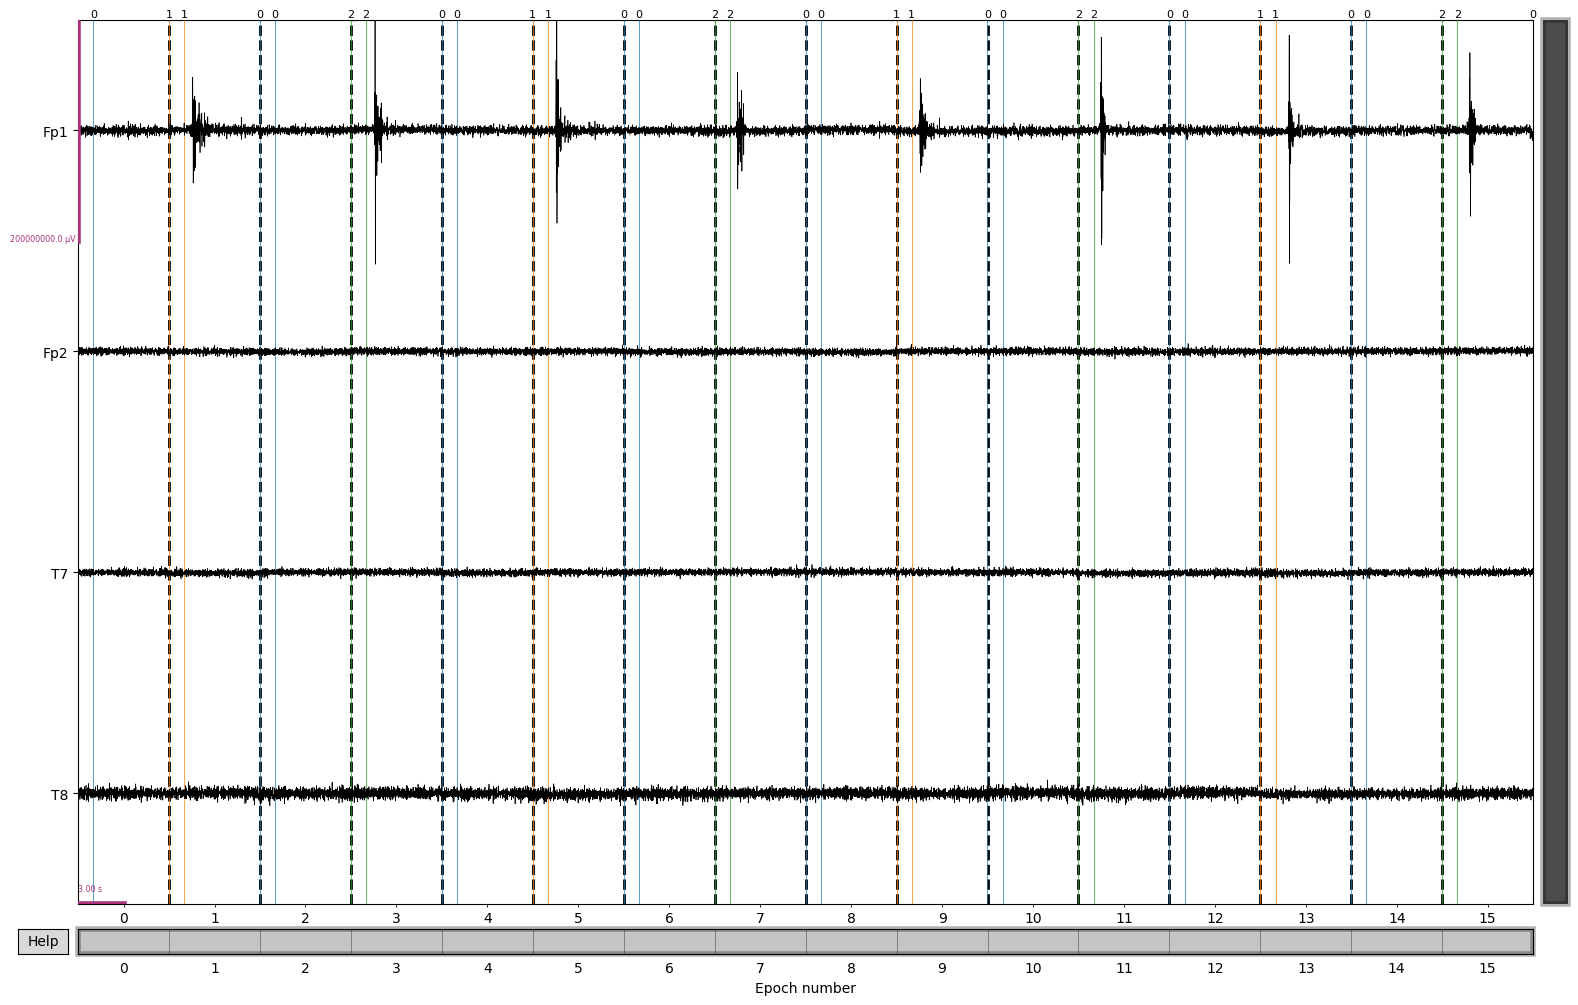

c:\Users\cscrawford\Documents\phygo\venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\cscrawford\Documents\phygo\venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\cscrawford\Documents\phygo\venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Relax


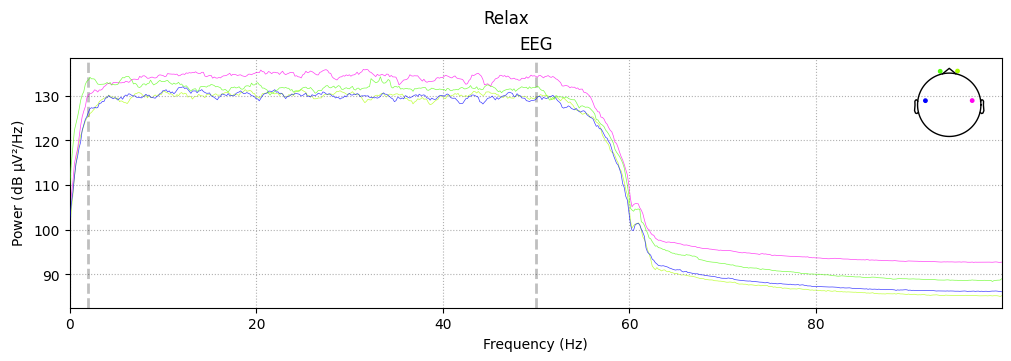

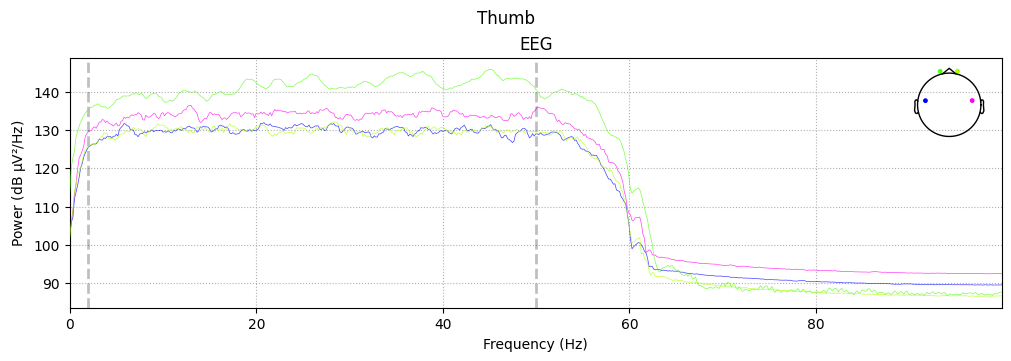

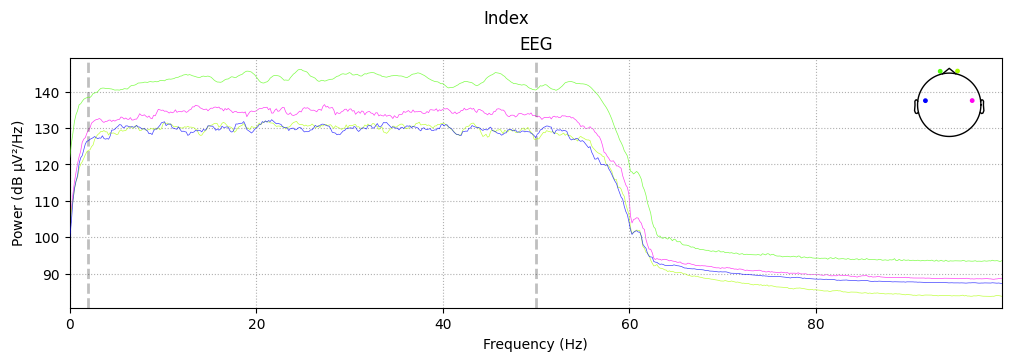

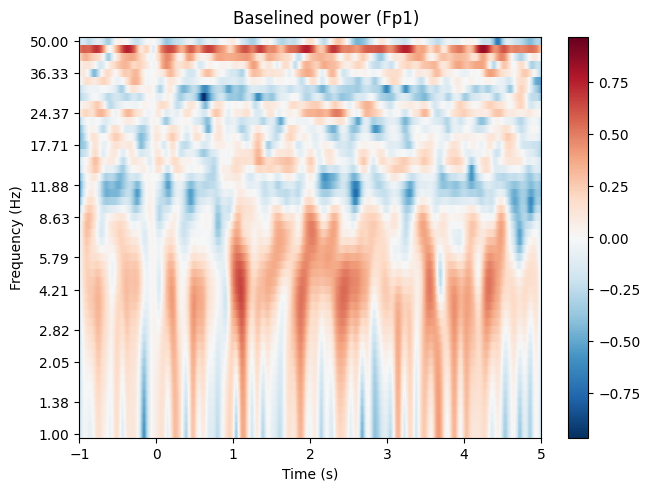

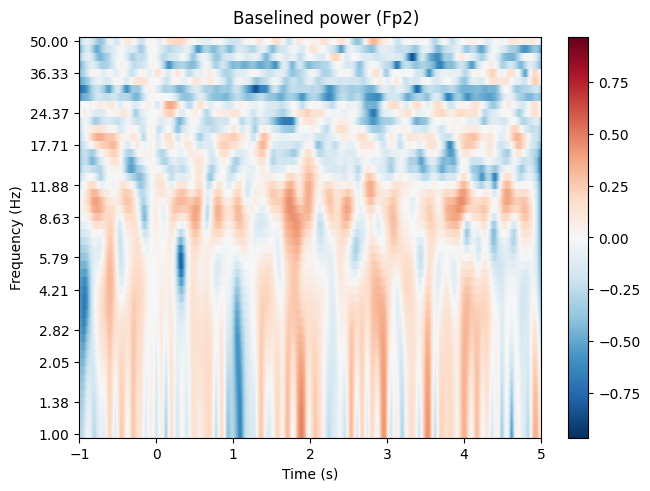

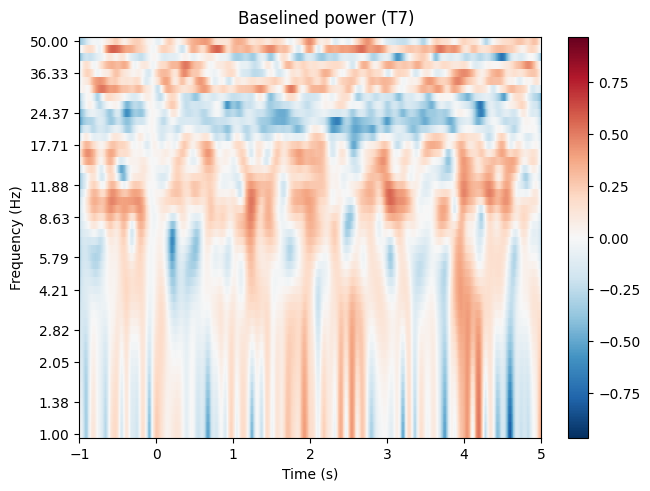

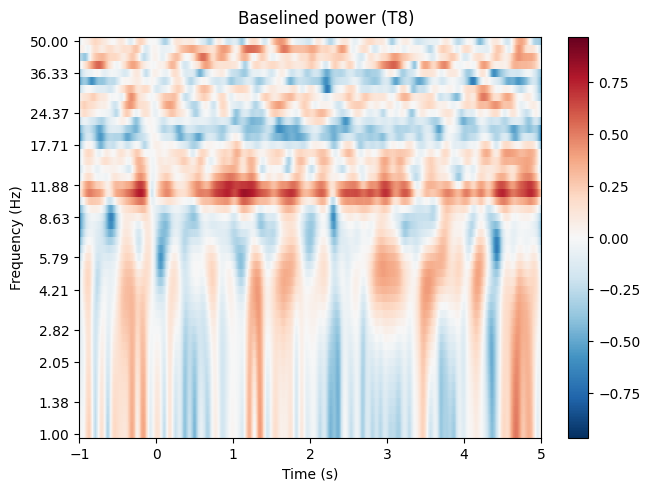

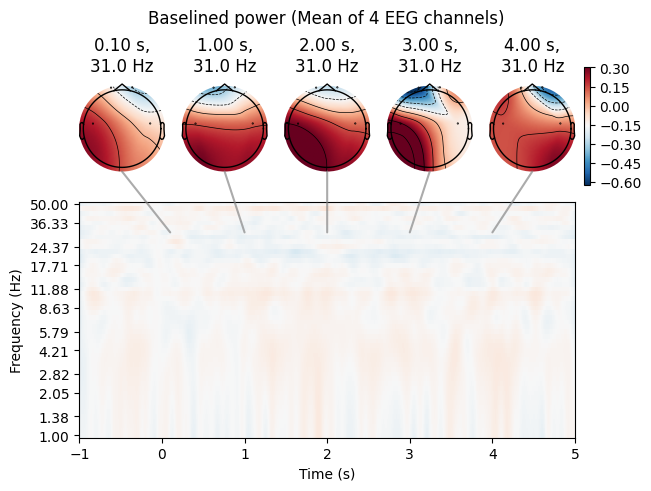

Thumb


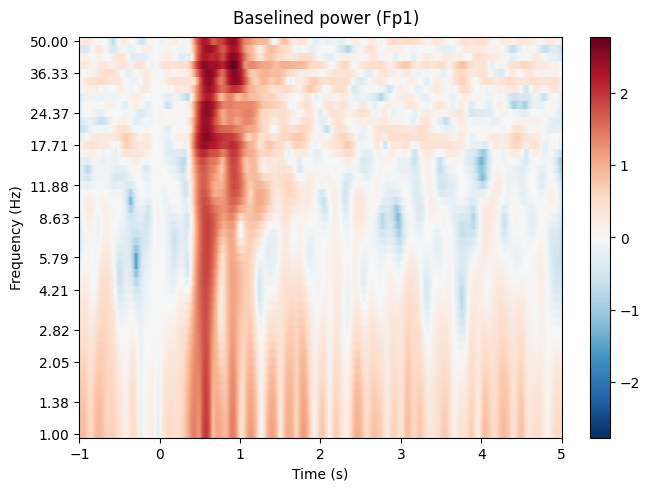

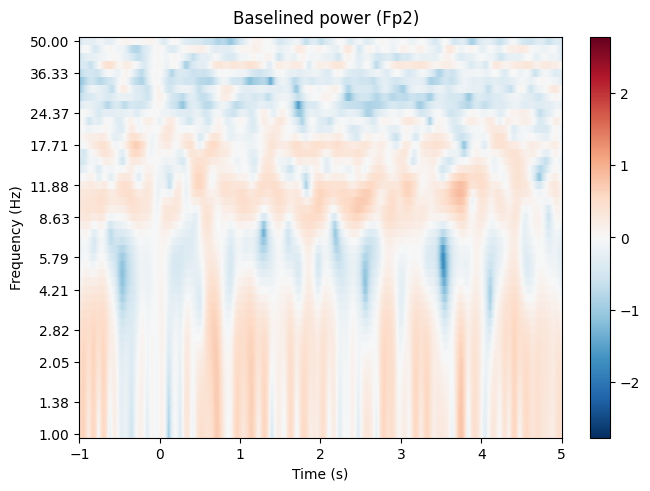

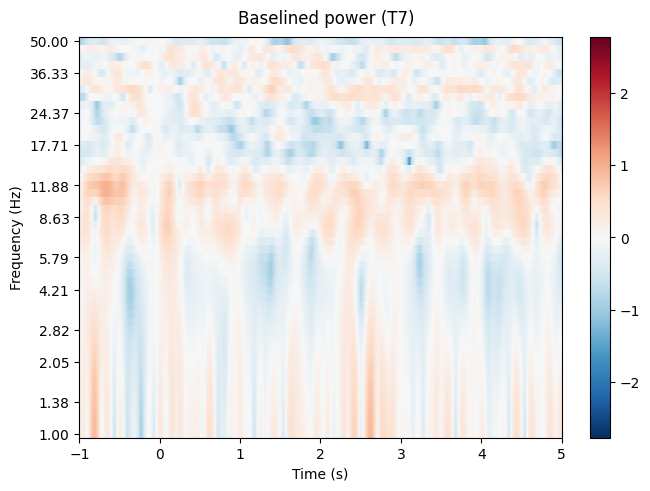

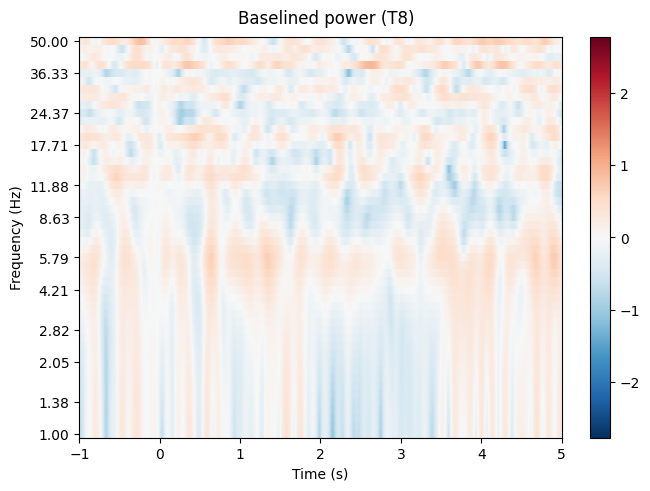

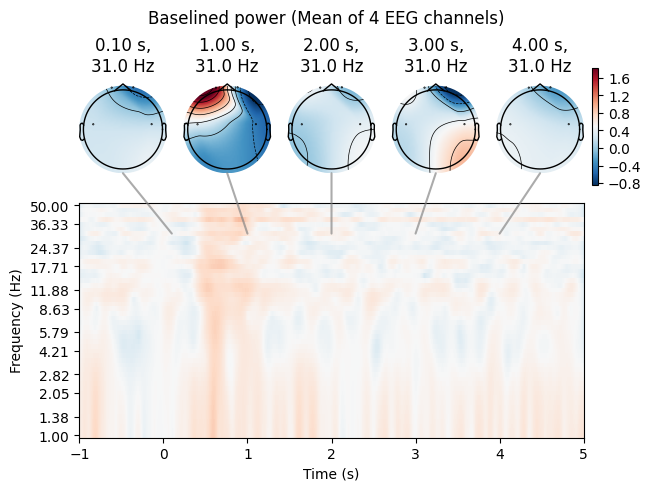

Index


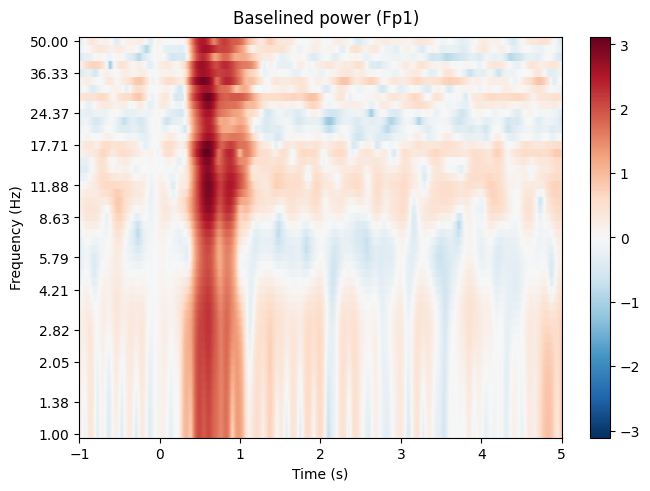

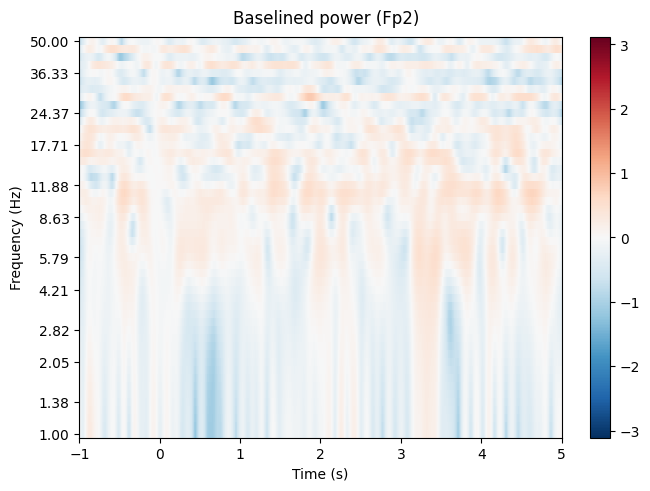

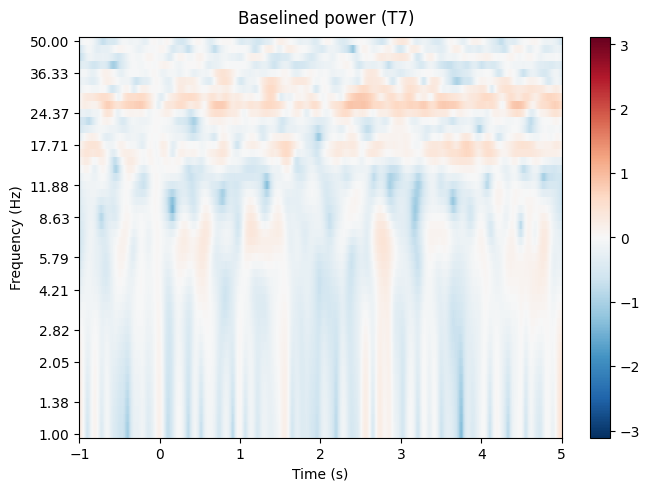

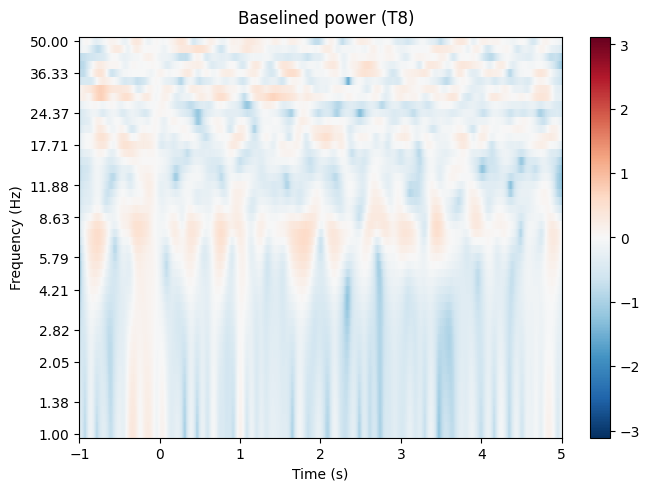

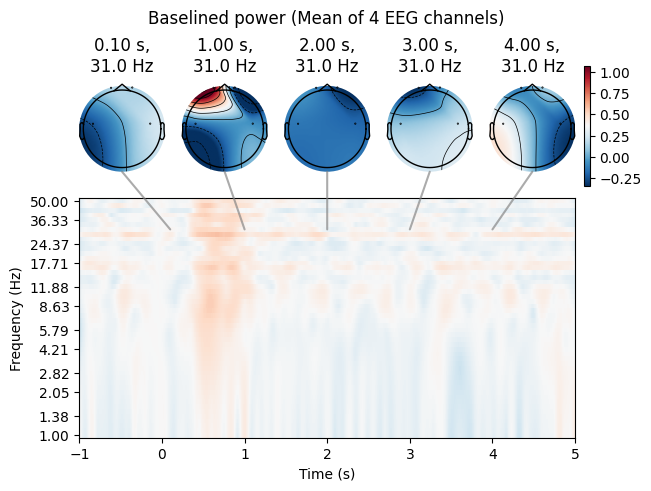

event_labels
['Relax' 'Thumb' 'Index']
Relax tfr


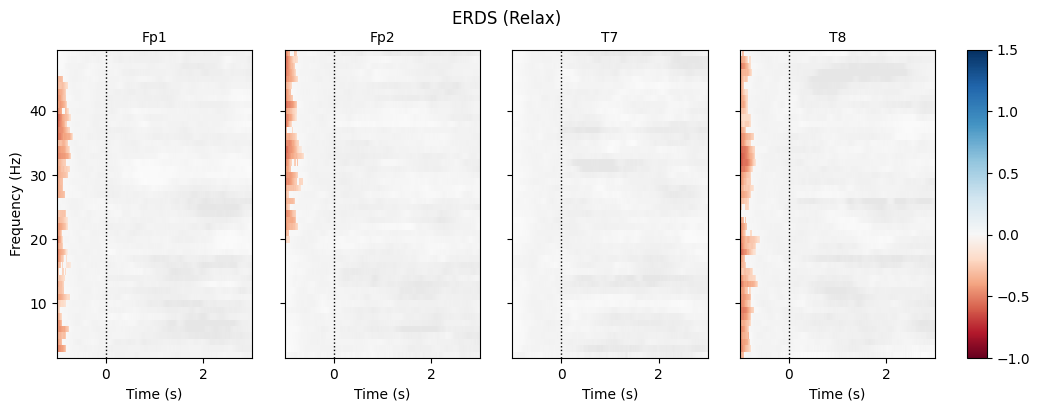

Thumb tfr


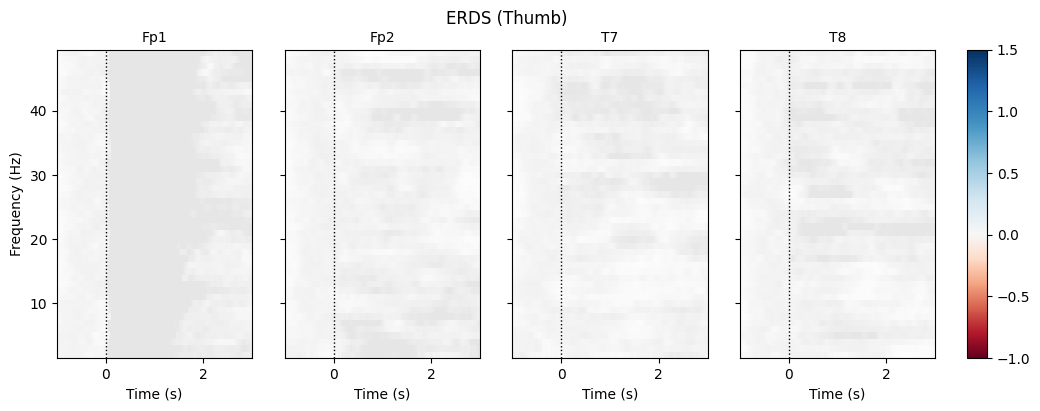

Index tfr


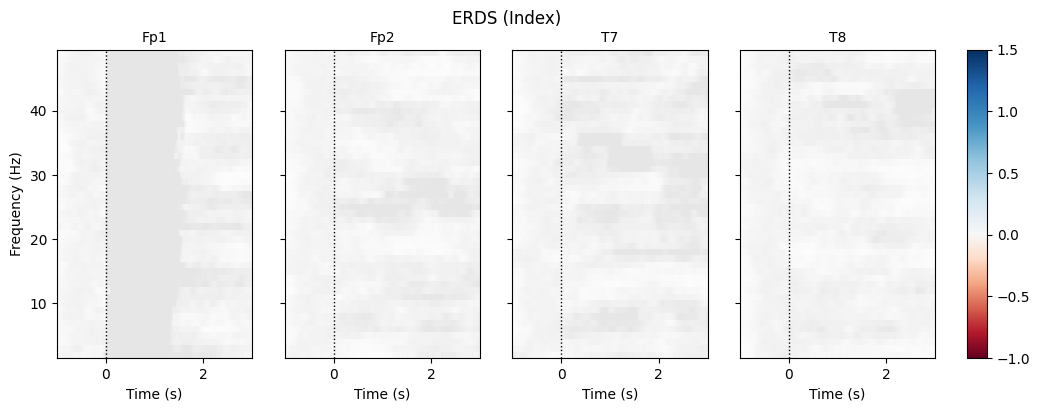

df.channel.unique()
['Fp1', 'Fp2', 'T7', 'T8']
Categories (4, object): ['Fp1', 'Fp2', 'T7', 'T8']


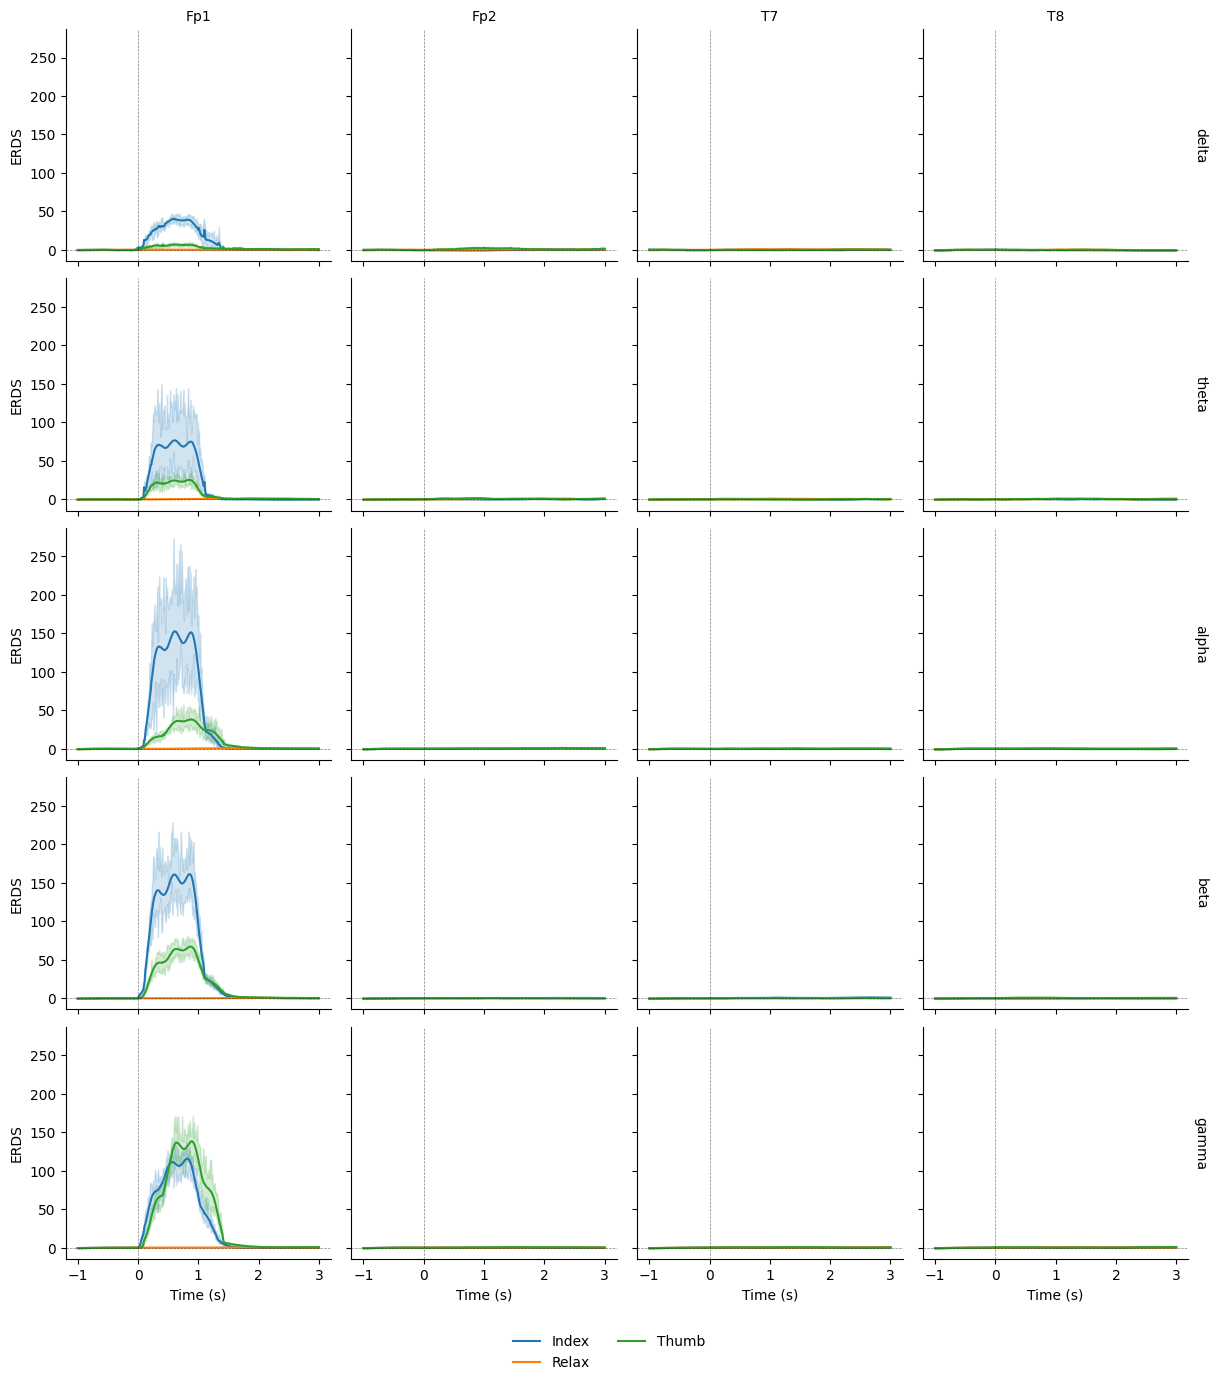

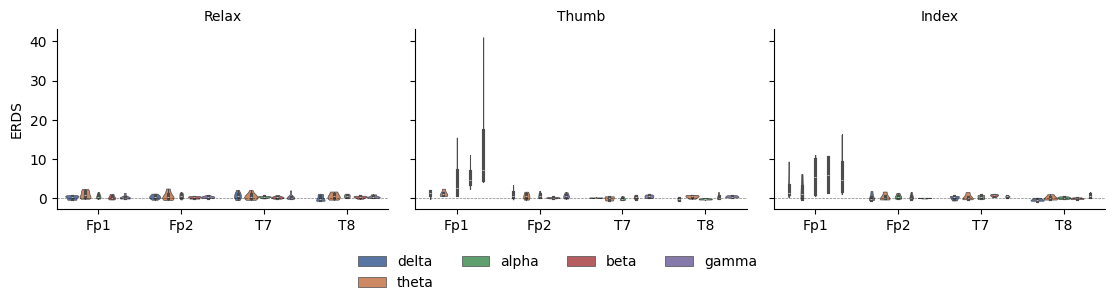

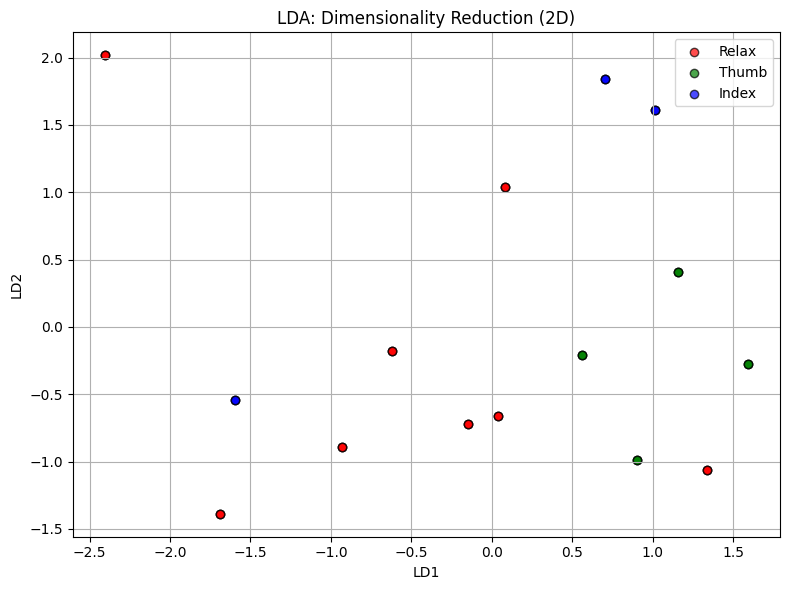

scores
[0.66666667 0.53333333 0.75555556 0.53333333 0.65555556]
mean score
0.6288888888888888


In [38]:
import mne
from pathlib import Path
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
import numpy as np
import matplotlib.pyplot as plt
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from matplotlib.colors import TwoSlopeNorm
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import seaborn as sns

# Disable MNE logging output
mne.set_log_level('ERROR')

class Study:
    def __init__(self, csv_file, event_file, event_labels_file, sfreq=200, setup_type="emg", tmin=0.0, tmax=2.0):
        self.csv_file = csv_file
        self.event_file = event_file
        # self.event_dict = event_dict
        self.dataset_x = list()
        self.dataset_y = list()
        self.sfreq = sfreq
        self.raw = None
        self.filtered = None
        self.epochs_filtered = None
        self.events = None
        self.lda = None
        self.event_labels_file = event_labels_file
        self.setup_type = setup_type
        self.eeg_ganglion_labels = ['Fp1', 'Fp2', 'T7', 'T8']
        self.fmax_dict = {
            "emg": 95,
            "eeg": 50
        }

        self.fmin_dict = {
            "emg": 1.0,
            "eeg": 2.0
        }
        self.baseline = (0.0, 0.1)
        self.tmin = tmin
        self.tmax = tmax
        self.target_joint_freq = 30
        self.joint_time_freqs = ((0.10, self.target_joint_freq), (1, self.target_joint_freq), (2, self.target_joint_freq), (3, self.target_joint_freq), (4, self.target_joint_freq))
        self.erds_window = {
            'min':-1.0,
            'max':3.0
        }
    
    def train(self, n_components=2, colors=['red', 'green', 'blue', 'purple']):
        lda = LinearDiscriminantAnalysis()
        self.dataset_x = np.array(self.dataset_x)
        self.dataset_y = np.array(self.dataset_y)
        X_lda = lda.fit_transform(self.dataset_x, self.dataset_y)
        plt.figure(figsize=(8, 6))
        
        if len(self.event_labels) < 3:
            plt.subplot(122)
            for i in range(len(self.event_labels)):
                plt.hist(X_lda[self.dataset_y==self.event_labels[i]], bins=20, alpha=0.5, label=self.event_labels[i])

            plt.title('LDA Projection')
            plt.xlabel('LD1')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            # Used when more than 2 classes are present
            # Create index array based on length of labels
            indices = np.arange(len(self.event_labels))
            for color, i, label in zip(colors, indices, self.event_labels):
                plt.scatter(X_lda[self.dataset_y == self.event_labels[i], 0], X_lda[self.dataset_y == self.event_labels[i], 1], alpha=0.7, color=color, label=label, edgecolor='k')

            plt.title('LDA: Dimensionality Reduction (2D)')
            plt.xlabel('LD1')
            plt.ylabel('LD2')
            plt.legend(loc='best')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        scores = cross_val_score(lda, self.dataset_x, self.dataset_y, cv=5, scoring='f1_macro', n_jobs=8)
        print("scores")
        print(scores)
        print("mean score")
        print(np.mean(scores))


    def get_pca(self, n_components=2, colors=['red', 'green', 'blue', 'purple']):
        print("get_pca")
        # Apply PCA to reduce dimensionality
        pca = PCA(n_components=n_components)
        
        print(self.dataset_x)
        print(self.dataset_y)
        X_pca = pca.fit_transform(self.dataset_x)

        # Create index array based on length of labels
        indices = np.arange(len(self.event_labels))

        # Plot the reduced data
        plt.figure(figsize=(8, 6))
        for color, i, label in zip(colors, indices, self.event_labels):
            plt.scatter(X_pca[self.dataset_y == i, 0], X_pca[self.dataset_y == i, 1], alpha=0.7, color=color, label=label, edgecolor='k')

        plt.title('PCA: Dimensionality Reduction (2D)')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def filter_data(self, raw, l_freq=1.0, h_freq=95.0):
        filtered = raw.copy().filter(l_freq=l_freq, h_freq=h_freq)
        self.filtered = filtered.notch_filter(freqs=60)
        return filtered

    def load_events(self, file_path):
        events = np.loadtxt(file_path, delimiter=',', dtype=int)
        return events
    
    def raw_to_epochs(self,raw, event_file, event_dict, tmin=0.1, tmax=2.0, baseline=None, reject=None):
        events = np.array(self.load_events(event_file))  
        epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=tmin, tmax=tmax, preload=True, baseline=baseline, reject=reject)
        psd = epochs.compute_psd()
        return epochs, events, psd

    def csv_to_dataframe(self, file):
        eeg_channels_names = [str(i) for i in range(15)]
        df = pd.read_csv(file, usecols = eeg_channels_names).transpose()
        return df

    def df_to_raw( self, df, sfreq=200, ch_types='emg'):
        # eeg_channels_names = BoardShim.get_eeg_names(self.board_id)
        eeg_channels_names = [str(i) for i in range(df.shape[0])]
        ch_types = ['eeg'] * len(eeg_channels_names)

        # Create MNE info object
        if self.setup_type == "emg":
            info = mne.create_info(ch_names = eeg_channels_names, sfreq = sfreq, ch_types=ch_types)
        elif self.setup_type == "eeg":
            info = mne.create_info(ch_names = self.eeg_ganglion_labels, sfreq = sfreq, ch_types=ch_types)

        # Create MNE raw object
        raw = mne.io.RawArray(df, info)
        raw.load_data()
        # raw.plot(clipping=None, scalings=dict(eeg='1e3', emg='1e5'))

        return raw

    def csv_to_raw(self, file, start_channel=0, end_channel=15):
        df = self.csv_to_dataframe(file)
        df = df.iloc[start_channel:end_channel, :]
        raw = self.df_to_raw(df)
        if self.setup_type == "eeg":
            raw.set_montage("standard_1020")
        return raw

    def get_band_powers(self, epoch):
        # Currently using featiures in 10hz bins inspired by: 
        # Saponas, T. S., Tan, D. S., Morris, D. & Balakrishnan, R. Demonstrating the feasibility of using forearm electromyography for muscle-computer interfaces. 515–524 (2008) doi:10.1145/1357054.1357138.
        if (self.setup_type == "emg"):
            [avgs, stddevs] = DataFilter.get_custom_band_powers(epoch, [(1,10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90)], [0], self.sfreq, False)
        elif (self.setup_type == "eeg"):
            [avgs, stddevs] = DataFilter.get_custom_band_powers(epoch, [(1,4), (4, 8)], [0, 1], self.sfreq, False)
        return avgs

    # def get_band_power_by_epoch(self, epochs, epoch_index):
    #     selected_epoch = epochs[epoch_index, :, :]
    #     avgs = self.get_band_powers(selected_epoch)
    #     return avgs
    


    # To update this function to change x values (input)
    def updated_get_band_power_by_epoch(self, tfr_df, tfr, epochs, event_id):
        max_epoch = np.array(tfr_df['epoch'].values).max()
        for epoch in range(max_epoch):
            if self.setup_type == "eeg":
                # mask =  (tfr_df['epoch'] == epoch ) & (tfr_df['channel'] == 'Fp1') & (tfr_df['band'] == 'delta') & (tfr_df['time'] > 2.0)
                # Use all channels
                mask =  (tfr_df['epoch'] == epoch ) & (tfr_df['band'] == 'gamma') & (tfr_df['time'] > 2.0)

            elif self.setup_type == "emg":
                mask =  (tfr_df['epoch'] == epoch ) & (tfr_df['channel'] == '0') & ((tfr_df['band'] == 'gamma4')) & (tfr_df['time'] > 2.0)
            
            filtered_df = tfr_df[mask]
            values = filtered_df['value'].values
            label = np.array(filtered_df['condition'].values)[0]
            self.dataset_x.append(values)
            self.dataset_y.append(label)

        # this works but performs worse
        # epochs_data = epochs[event_id].get_data()
        # for i in range(epochs_data.shape[0]):
        #     avgs = self.get_band_power_by_epoch(epochs_data, i)
        #     self.dataset_x.append(avgs)
        #     self.dataset_y.append(event_id)


    def plot_band_powers(self, avgs, title="Average Band Powers"):
        # Create bar plot of average band powers
        plt.figure(figsize=(10,6))
        bands = ['(1-10Hz)', '(10-20Hz)', '(20-30Hz)', '(40-50Hz)', 
                '(50-60Hz)', '(70-80Hz)', '(80-90Hz)']
        plt.bar(bands, avgs)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Power')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def plot_tfr(self, epochs, event):
        # Time frequency analysis
        fmax =  self.fmax_dict[self.setup_type]
        freqs = np.logspace(*np.log10([1, fmax]), num=fmax)
        n_cycles = freqs / 2.0
        baseline = (-0.1, 0)

        epochs_tfr = epochs[event].compute_tfr("morlet", n_cycles=n_cycles, return_itc=False, freqs=freqs, average=True, use_fft=True)
        epochs_tfr.plot(title='auto', baseline=baseline, mode="logratio", yscale="log") # vmax=1e-8,
        return epochs_tfr
    
    
    def get_erds(self, epochs):
        # https://mne.tools/stable/auto_examples/time_frequency/time_frequency_erds.html#cnorm-example
        freqs = np.arange(2, self.fmax_dict[self.setup_type])  # frequencies from 2-35Hz
        vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
        baseline = (-1, 0)  # baseline interval (in s)
        cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

        tfr = epochs.compute_tfr(
            method="multitaper",
            freqs=freqs,
            n_cycles=freqs,
            use_fft=True,
            return_itc=False,
            average=False,
            decim=2,
        )

        kwargs = dict(
            n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
        )  # for cluster test

        tfr.crop(self.erds_window['min'], self.erds_window['max']).apply_baseline(baseline, mode="percent")
        print("event_labels")
        print(self.event_labels)
        for event in self.event_labels:
            print(event, "tfr")
            tfr_ev = tfr[event]
            
            if self.setup_type == "eeg":
                fig, axes = plt.subplots(1, 5, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 10, 1]})
            elif self.setup_type == "emg":
                fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 1]})
            
            for ch, ax in enumerate(axes[:-1]):  # for each channel
                # positive clusters
                _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
                # negative clusters
                _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

                # note that we keep clusters with p <= 0.05 from the combined clusters
                # of two independent tests; in this example, we do not correct for
                # these two comparisons
                c = np.stack(c1 + c2, axis=2)  # combined clusters
                p = np.concatenate((p1, p2))  # combined p-values
                mask = c[..., p <= 0.05].any(axis=-1)

                # plot TFR (ERDS map with masking)
                tfr_ev.average().plot(
                    [ch],
                    cmap="RdBu",
                    cnorm=cnorm,
                    axes=ax,
                    colorbar=False,
                    show=False,
                    mask=mask,
                    mask_style="mask",
                )

                ax.set_title(epochs.ch_names[ch], fontsize=10)
                ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
                if ch != 0:
                    ax.set_ylabel("")
                    ax.set_yticklabels("")
            fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
            fig.suptitle(f"ERDS ({event})")
            plt.show()
        return tfr

    def plot_ersd_linegraph(self, df):
        # https://mne.tools/stable/auto_examples/time_frequency/time_frequency_erds.html#cnorm-example
        # Filter to retain only relevant frequency bands:
        if self.setup_type == "eeg":
            freq_bands_of_interest = ["delta", 'theta', 'alpha', 'beta', 'gamma']
        elif self.setup_type == "emg":
            freq_bands_of_interest = ["delta", 'theta', 'alpha', 'beta', 'gamma', 'gamma1', 'gamma2', 'gamma3', 'gamma4']

        df = df[df.band.isin(freq_bands_of_interest)]
        df["band"] = df["band"].cat.remove_unused_categories()

        # Order channels for plotting:
        if self.setup_type == "eeg":
            df["channel"] = df["channel"].cat.reorder_categories(('Fp1', 'Fp2', 'T7', 'T8'), ordered=True)
        elif self.setup_type == "emg":
            df = df.loc[df.channel == '0']
            df["channel"] = df["channel"].cat.remove_unused_categories()

        # print("Channel values:", df.channel.unique())

        g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
        g.map(sns.lineplot, "time", "value", "condition", n_boot=10)
        axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
        g.map(plt.axhline, y=0, **axline_kw)
        g.map(plt.axvline, x=0, **axline_kw)
        # g.set(ylim=(None, 1.5))
        g.set_axis_labels("Time (s)", "ERDS")
        g.set_titles(col_template="{col_name}", row_template="{row_name}")
        g.add_legend(ncol=2, loc="lower center")
        g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

    def erds_violin(self, df):
        axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
        df["band"] = df["band"].cat.reorder_categories(('delta', 'theta', 'alpha', 'beta', 'gamma', 'gamma1', 'gamma2', 'gamma3', 'gamma4'), ordered=True)


        if self.setup_type == "eeg":
            channels = ['Fp1', 'Fp2', 'T7', 'T8']
            freq_bands_of_interest = ['delta', 'theta', 'alpha', 'beta', 'gamma']
        elif self.setup_type == "emg":
            channels = ['0']
            freq_bands_of_interest = ['gamma', 'gamma1', 'gamma2', 'gamma3', 'gamma4']
        else:
            channels = ['0']
            freq_bands_of_interest = ['delta', 'theta', 'alpha', 'beta', 'gamma']



        df_mean = (
            df.query("time > 1")
            .groupby(["condition", "epoch", "band", "channel"], observed=False)[["value"]]
            .mean()
            .reset_index()
        )

        g = sns.FacetGrid(
            df_mean, col="condition", col_order=self.event_labels, margin_titles=True
        )
        g = g.map(
            sns.violinplot,
            "channel",
            "value",
            "band",
            cut=0,
            palette="deep",
            order=channels,
            hue_order=freq_bands_of_interest,
            linewidth=0.5,
        ).add_legend(ncol=4, loc="lower center")

        g.map(plt.axhline, **axline_kw)
        g.set_axis_labels("", "ERDS")
        g.set_titles(col_template="{col_name}", row_template="{row_name}")
        g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)
    
    def run_study(self, csv_file, event_file, plot_epochs=False, plot_tfr=False):
        fmax = self.fmax_dict[self.setup_type]
        fmin = self.fmin_dict[self.setup_type]
        if self.setup_type == "emg":
            self.raw = self.csv_to_raw(csv_file, 1, 5)
        elif self.setup_type == "eeg":
            self.raw = self.csv_to_raw(csv_file, 1, 5)

        self.filtered = self.filter_data(self.raw, l_freq=fmin, h_freq=fmax)
        self.event_labels =  np.loadtxt(self.event_labels_file, delimiter=',', dtype=str)
        self.event_dict = {str(label): i for i, label in enumerate(self.event_labels)}
        epochs_filtered, events, psd = self.raw_to_epochs(self.filtered, event_file, self.event_dict, tmin=self.tmin, tmax=self.tmax, baseline=self.baseline)
        self.epochs_filtered = epochs_filtered
        
        if plot_epochs:
            self.epochs_filtered.plot(scalings=dict(eeg='1e2', emg='1e5'), events=events)
            for event_label in self.event_labels:
                fig = psd[event_label].plot()
                fig.suptitle(f"{event_label}")

        self.events = events

        if plot_tfr:
            for event in self.event_labels:
                print(event)
                epochs_tfr = self.plot_tfr(self.epochs_filtered, event)
                target_freq = 30
                if self.setup_type == "eeg":
                    epochs_tfr.plot_joint(title='auto', picks=self.eeg_ganglion_labels, timefreqs=self.joint_time_freqs,  baseline=(-0.1, 0), mode="logratio", vlim=(-3, 3))
        
        tfr = self.get_erds(epochs_filtered)
        df = tfr.to_data_frame(time_format=None, long_format=True)

        freq_bounds = {"_": 0,  "delta": 3, "theta": 7, "alpha": 13, "beta": 35,  "gamma": 50, 'gamma1': 60, 'gamma2': 70, 'gamma3': 80, 'gamma4': 90}

        df["band"] = pd.cut(
            df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
        )

        for event_name, event_id in self.event_dict.items():
            self.updated_get_band_power_by_epoch(df, tfr, self.epochs_filtered, event_name)
        
        self.plot_ersd_linegraph(df)
        self.erds_violin(df)
        print("df.channel.unique()")
        print(df.channel.unique())

    def run(self, plot_epochs=False, plot_tfr=False):
        self.run_study(self.csv_file, self.event_file, plot_epochs, plot_tfr=plot_tfr)

study_name = "study3"
study = Study(f"data/{study_name}_data.csv", f"events/{study_name}.txt", f"events/{study_name}_event_labels.txt", setup_type="eeg", tmin=-1.0, tmax=5.0)
study.run(True,  plot_tfr=True)
study.train()
# study.get_pca()
# study.get_lda_new()





